In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import netCDF4 as nc
import xarray as xr
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools, places
import gsw 
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import math
from scipy import io
import pickle
import cmocean
from salishsea_tools import Keegan_eval_tools as ket
import json
from collections import OrderedDict
from matplotlib.colors import LogNorm
import arrow
import glob
import datetime
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from matplotlib.dates import HourLocator, MonthLocator, YearLocator

fs=16
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

import warnings
#warnings.filterwarnings('ignore')
from IPython.display import Markdown, display

%matplotlib inline

In [2]:
with nc.Dataset('/ocean/ksuchy/MOAD/NEMO-forcing/grid/mesh_mask202108.nc') as mesh:
    tmask=np.copy(mesh.variables['tmask'][0,:,:,:])
    navlat=np.copy(mesh.variables['nav_lat'][:,:])
    navlon=np.copy(mesh.variables['nav_lon'][:,:])

## Bring in grid coordinates for slice/box of interest

In [3]:
ii, ij = 450,500
ji, jj = 250,300


In [4]:
CentralSoG = [450, 500,250,300]

In [5]:
yearList = [2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]

data = 'month-avg.202111'
#year = '2014'
month = '01'
file = 'prod'

for year in yearList:
    files=[glob.glob(f'/results2/SalishSea/{data}/SalishSeaCast_1m_{file}_T_*{year}*{month:02d}01_*{year}*{month:02d}??.nc')[0] for year in yearList for month in range(1,13) ]
    

In [6]:
f=xr.open_mfdataset('/results2/SalishSea/month-avg.202111/SalishSeaCast_1m_prod_T_20240801_20240831.nc')

In [7]:
f

<xarray.Dataset>
Dimensions:    (time: 1, depth: 40, gridY: 898, gridX: 398)
Coordinates:
  * depth      (depth) float32 0.5 1.5 2.5 3.5 4.5 ... 360.7 387.6 414.5 441.5
  * gridY      (gridY) int64 0 1 2 3 4 5 6 7 ... 890 891 892 893 894 895 896 897
  * gridX      (gridX) int64 0 1 2 3 4 5 6 7 ... 390 391 392 393 394 395 396 397
  * time       (time) datetime64[ns] 2024-08-15T12:00:00
Data variables:
    PPDIAT     (time, depth, gridY, gridX) float32 dask.array<chunksize=(1, 40, 898, 398), meta=np.ndarray>
    PPPHY      (time, depth, gridY, gridX) float32 dask.array<chunksize=(1, 40, 898, 398), meta=np.ndarray>
    PPDIATNO3  (time, depth, gridY, gridX) float32 dask.array<chunksize=(1, 40, 898, 398), meta=np.ndarray>
    PPPHYNO3   (time, depth, gridY, gridX) float32 dask.array<chunksize=(1, 40, 898, 398), meta=np.ndarray>
    TQ10       (time, depth, gridY, gridX) float32 dask.array<chunksize=(1, 40, 898, 398), meta=np.ndarray>
Attributes:
    name:         SalishSeaCast_1m_prod_T_20240801_20240831
    description:  Month-averaged biology growth rate variables resampled from...
    history:      2024-09-26 12:11 -07:00: Generated by reshapr.api.v1.extrac...
    Conventions:  CF-1.6

In [8]:
## Gathering metadata but still not opening the files
dsfiles = xr.open_mfdataset(
        files,
        #chunks=chunk_size,
        compat="override",
        coords="minimal",
        data_vars="minimal",
        drop_variables=['PPDIATNO3','PPPHYNO3','TQ10'],
        parallel=True,
        engine='netcdf4'
    )

In [9]:
np.shape(CentralSoG)

(4,)

In [10]:
np.shape(dsfiles.time)

(192,)

In [11]:
dsfiles.PPDIAT

<xarray.DataArray 'PPDIAT' (time: 192, depth: 40, gridY: 898, gridX: 398)>
dask.array<concatenate, shape=(192, 40, 898, 398), dtype=float32, chunksize=(1, 40, 898, 398), chunktype=numpy.ndarray>
Coordinates:
  * depth    (depth) float32 0.5 1.5 2.5 3.5 4.5 ... 360.7 387.6 414.5 441.5
  * gridY    (gridY) int64 0 1 2 3 4 5 6 7 8 ... 890 891 892 893 894 895 896 897
  * gridX    (gridX) int64 0 1 2 3 4 5 6 7 8 ... 390 391 392 393 394 395 396 397
  * time     (time) datetime64[ns] 2007-01-15T12:00:00 ... 2022-12-15T12:00:00
Attributes:
    standard_name:  tendency_of_mole_concentration_of_diatoms_expressed_as_ni...
    long_name:      Primary Production of Diatoms
    units:          mmol N m-3 s-1

In [12]:
np.shape(tmask) 

(40, 898, 398)

In [13]:
## tmask has no time so we need to broadcast_to 192 (12 x # of years in time series)

In [14]:
newmask=np.broadcast_to(tmask[:,CentralSoG[0]:CentralSoG[1], 
                               CentralSoG[2]:CentralSoG[3]],(192,40,50,50))

In [15]:
np.shape(newmask) 

(192, 40, 50, 50)

In [17]:
tt=np.array(dsfiles.time)
mod_depth=np.array(dsfiles.depth)
mod_PPDIAT=(dsfiles.PPDIAT[:,:, CentralSoG[0]:CentralSoG[1], 
                               CentralSoG[2]:CentralSoG[3]])
mod_PPDIAT = (np.array(mod_PPDIAT))

mod_PPDIAT = np.ma.masked_where(newmask==0,mod_PPDIAT) ## masking where there is land



mod_PPPHY=(dsfiles.PPPHY[:,:, CentralSoG[0]:CentralSoG[1], 
                               CentralSoG[2]:CentralSoG[3]])
mod_PPPHY = (np.array(mod_PPPHY))

mod_PPPHY = np.ma.masked_where(newmask==0,mod_PPPHY) ## masking where there is land

In [18]:
dsfiles.close()

In [19]:
mod_PPDIAT = mod_PPDIAT.T ## transpose the variable to make it work with the Hovmoller plots
mod_PPPHY = mod_PPPHY.T

In [20]:
np.shape(mod_PPDIAT)

(50, 50, 40, 192)

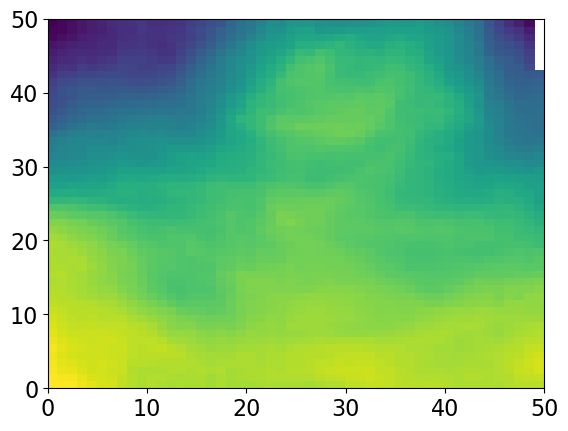

In [21]:
## Check to see what is there

plt.pcolormesh(mod_PPDIAT[:,:,0,0]) ## viewing the first depth at the first time stamp; remember z and t are the last two axes here


## Dataset for climatology

In [22]:
clim=nc.Dataset('/results2/SalishSea/month-avg.202111/SalishSeaCast_month_climatology_prod_T_20070101_20231231.nc')

In [23]:
clim.variables.keys()

dict_keys(['PPDIAT', 'PPPHY', 'PPDIATNO3', 'PPPHYNO3', 'TQ10', 'depth', 'gridY', 'gridX', 'month'])

In [24]:
climmask=np.broadcast_to(tmask[:,CentralSoG[0]:CentralSoG[1], 
                               CentralSoG[2]:CentralSoG[3]],(12,40,50,50)) ## mask for climatology files

In [27]:
clim_mod_diat=np.ma.masked_where(climmask==0,clim['PPDIAT'][:,:, CentralSoG[0]:CentralSoG[1], 
                               CentralSoG[2]:CentralSoG[3]])

clim_mod_flag=np.ma.masked_where(climmask==0,clim['PPPHY'][:,:, CentralSoG[0]:CentralSoG[1], 
                               CentralSoG[2]:CentralSoG[3]])

In [28]:
## Designate date_range for Hovmoller plots

start= dt.datetime(2007,1,1)
end=dt.datetime(2022,12,31)

In [29]:
date_range=(start,end)

In [30]:
np.shape(mod_PPDIAT)

(50, 50, 40, 192)

In [31]:
np.shape(mod_depth)

(40,)

In [50]:
mod_PPDIAT_mean=np.mean(mod_PPDIAT, axis=(0, 1)) ## calculate the mean across the entire slice/box 4d to 2d array

In [51]:
mod_PPPHY_mean=np.mean(mod_PPPHY, axis=(0, 1)) ## calculate the mean across the entire slice/box 4d to 2d array

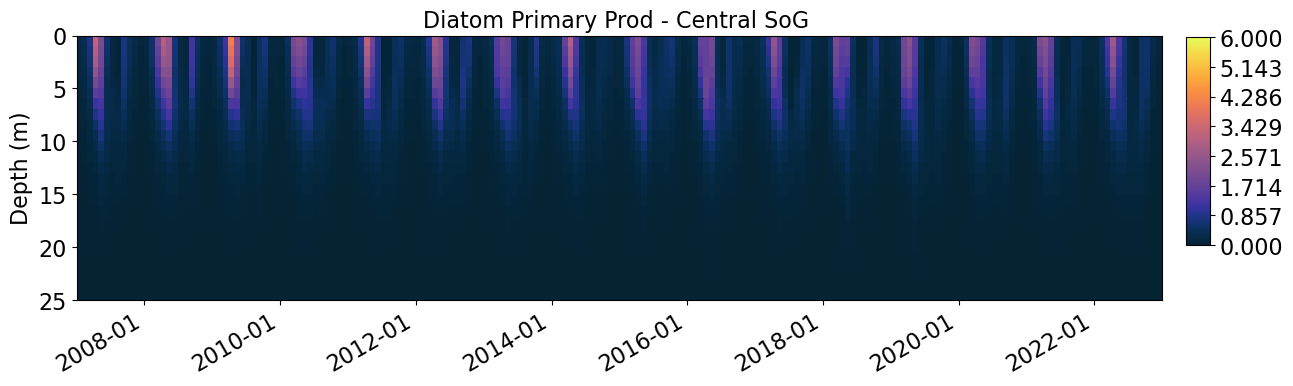

In [52]:

ax=ket.hovmoeller(mod_PPDIAT_mean[:,:]*86400, mod_depth, tt,(0,25),date_range, title='Diatom Primary Prod - Central SoG ',
               var_title='',vmax=0,vmin=6,cmap=cmo.cm.thermal)



ax.set_ylabel('Depth (m)')
ax.set_xlabel('')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))



In [53]:
np.shape(mod_PPDIAT_mean)

(40, 192)

In [54]:
np.shape(clim)

()

In [55]:
clim_diat_mean=np.mean(clim_mod_diat, axis=(2, 3)) ## Now have to calculate climatology mean across the entire slice/box 4d to 2d array
clim_flag_mean=np.mean(clim_mod_flag, axis=(2, 3))

In [56]:
np.shape(clim_diat_mean) ## climatology is only for 12 months

(12, 40)

In [57]:
### This isn't pretty, but I could not figure out how to repeat the climatology for all years in the time series
### np.repeat did not repeat on the proper axes

year1_D=clim_diat_mean[:,:] #.swapaxes(1,0)
year2_D=clim_diat_mean[:,:] #.swapaxes(1,0)                
year3_D=clim_diat_mean[:,:] #.swapaxes(1,0)                
year4_D=clim_diat_mean[:,:] #.swapaxes(1,0)                
year5_D=clim_diat_mean[:,:] #.swapaxes(1,0)                
year6_D=clim_diat_mean[:,:] #.swapaxes(1,0)  
year7_D=clim_diat_mean[:,:] #.swapaxes(1,0)
year8_D=clim_diat_mean[:,:] #.swapaxes(1,0)
year9_D=clim_diat_mean[:,:] #.swapaxes(1,0)
year10_D=clim_diat_mean[:,:] #.swapaxes(1,0)
year11_D=clim_diat_mean[:,:] #.swapaxes(1,0)
year12_D=clim_diat_mean[:,:] #.swapaxes(1,0)
year13_D=clim_diat_mean[:,:] #.swapaxes(1,0)
year14_D=clim_diat_mean[:,:] #.swapaxes(1,0)
year15_D=clim_diat_mean[:,:] #.swapaxes(1,0)
year16_D=clim_diat_mean[:,:] #.swapaxes(1,0)                

In [58]:
year1_F=clim_flag_mean[:,:] #.swapaxes(1,0)
year2_F=clim_flag_mean[:,:] #.swapaxes(1,0)                
year3_F=clim_flag_mean[:,:] #.swapaxes(1,0)                
year4_F=clim_flag_mean[:,:] #.swapaxes(1,0)                
year5_F=clim_flag_mean[:,:] #.swapaxes(1,0)                
year6_F=clim_flag_mean[:,:] #.swapaxes(1,0)  
year7_F=clim_flag_mean[:,:] #.swapaxes(1,0)
year8_F=clim_flag_mean[:,:] #.swapaxes(1,0)
year9_F=clim_flag_mean[:,:] #.swapaxes(1,0)
year10_F=clim_flag_mean[:,:] #.swapaxes(1,0)
year11_F=clim_flag_mean[:,:] #.swapaxes(1,0)
year12_F=clim_flag_mean[:,:] #.swapaxes(1,0)
year13_F=clim_flag_mean[:,:] #.swapaxes(1,0)
year14_F=clim_flag_mean[:,:] #.swapaxes(1,0)
year15_F=clim_flag_mean[:,:] #.swapaxes(1,0)
year16_F=clim_flag_mean[:,:] #.swapaxes(1,0)   

In [59]:
np.shape(year1_D)

(12, 40)

In [60]:
## Concatentate all of the above files to get sequential climatologies across the time series
clim_PPDIAT=np.concatenate((year1_D,year2_D,year3_D,year4_D,year5_D,year6_D, year7_D, year8_D,year9_D,year10_D,\
                         year11_D,year12_D,year13_D,year14_D,year15_D,year16_D), axis=0)

In [61]:
clim_PPPHY=np.concatenate((year1_F,year2_F,year3_F,year4_F,year5_F,year6_F, year7_F, year8_F,year9_F,year10_F,\
                         year11_F,year12_F,year13_F,year14_F,year15_F,year16_F), axis=0)

In [62]:
np.shape(clim_PPDIAT)

(192, 40)

In [63]:
clim_PPDIAT=clim_PPDIAT.T ## Transpose to match with the other variable
clim_PPPHY=clim_PPPHY.T

In [64]:
np.shape(clim_PPDIAT)

(40, 192)

In [67]:
(mod_PPDIAT_mean-clim_PPDIAT).min()*86400

-0.8240270270337268

In [68]:
(mod_PPDIAT_mean[:,:]-clim_PPDIAT[:,:]).max()*86400

1.6031416744962064

In [70]:
clim_PPDIAT*86400

masked_array(
  data=[[1.76630661e-01, 4.43023013e-01, 1.60934994e+00, ...,
         5.73178254e-01, 2.17006396e-01, 1.33852268e-01],
        [1.58072519e-01, 4.02535665e-01, 1.49707157e+00, ...,
         5.41675693e-01, 1.95722002e-01, 1.16842592e-01],
        [1.42077289e-01, 3.62054385e-01, 1.37236544e+00, ...,
         5.06270082e-01, 1.76186564e-01, 1.02359317e-01],
        ...,
        [5.97249108e-20, 8.11277848e-20, 6.36923127e-20, ...,
         4.34669471e-19, 1.52238561e-19, 7.18846581e-20],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],
  mask=False,
  fill_value=1e+20)

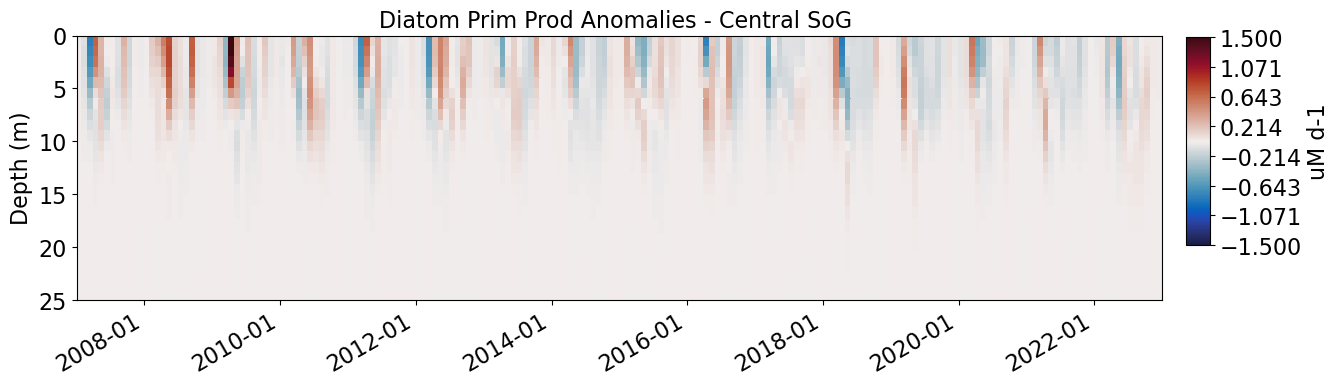

In [74]:
ax=ket.hovmoeller((mod_PPDIAT_mean-clim_PPDIAT)*86400, mod_depth, tt,(0,25),date_range, title='Diatom Prim Prod Anomalies - Central SoG ',
               var_title='uM d-1',vmax=-1.5,vmin=1.5,cmap=cmo.cm.balance)



ax.set_ylabel('Depth (m)')
ax.set_xlabel('')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))


#contour_value = 9 
#contour = ax.contour(tt, mod_depth, mod_PPDIAT, levels=[contour_value], colors='mediumslateblue')

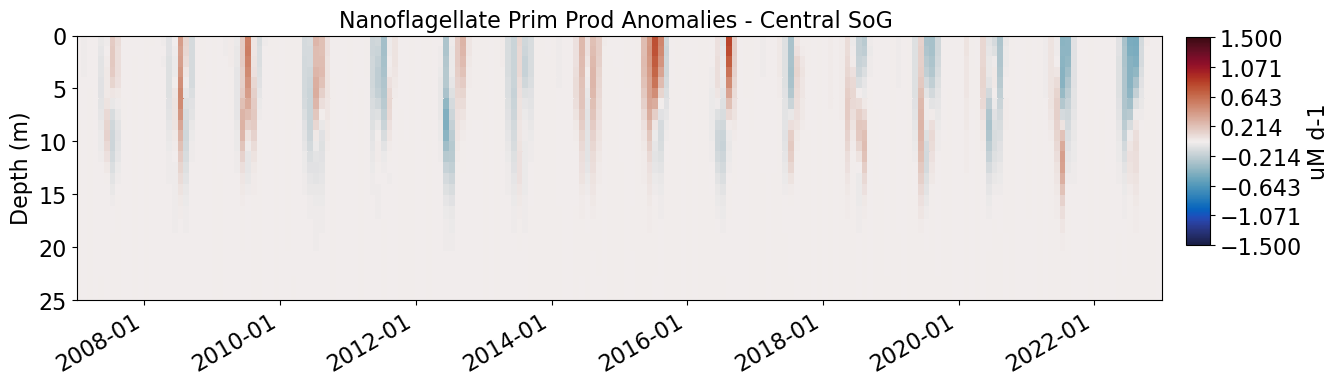

In [73]:
ax=ket.hovmoeller((mod_PPPHY_mean-clim_PPPHY)*86400, mod_depth, tt,(0,25),date_range, title='Nanoflagellate Prim Prod Anomalies - Central SoG ',
               var_title='uM d-1',vmax=-1.5,vmin=1.5,cmap=cmo.cm.balance)



ax.set_ylabel('Depth (m)')
ax.set_xlabel('')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Calculate anomalies across specific depth ranges

## Diatom Primary Productivity

In [78]:
mean_anomalies_surf_diatPP=np.mean((mod_PPDIAT_mean[0:20]-clim_PPDIAT[0:20])*86400,axis=0) ##20 = 25m depth

In [80]:
np.shape(mean_anomalies_surf_diatPP)

(192,)

In [81]:
np.shape(tt)

(192,)

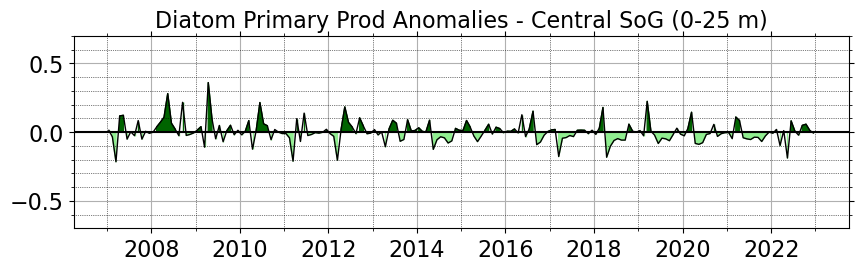

In [104]:
## mean anomalies for surface (0-50m) only

fig,ax=plt.subplots(1,1,figsize=(10,2.5))
x=tt
y=mean_anomalies_surf_diatPP


ax.plot(x,y,color='k',linewidth=1)
ax.set_ylim(-.7,.7)
plt.grid(True)
ax.minorticks_on()
#plt.grid(which='major',axis ='y', linewidth='1', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
ax.tick_params(which='both', # Options for both major and minor ticks
                top='off', # turn off top ticks
                left='off', # turn off left ticks
                right='off',  # turn off right ticks
                bottom='off') # turn off bottom ticks
hloc = YearLocator(1)
ax.xaxis.set_minor_locator(hloc)

ax.axhline(y=0,color='k',linestyle='-')


ax.fill_between(x,y,where=y<0, color='lightgreen')
ax.fill_between(x,y,where=y>0, color='darkgreen')

ax.set_title('Diatom Primary Prod Anomalies - Central SoG (0-25 m)')
#plt.grid()
plt.show()

## Nanoflagellate Primary Productivity

In [84]:
mean_anomalies_surf_flagPP=np.mean((mod_PPPHY_mean[0:20]-clim_PPPHY[0:20])*86400,axis=0) ##20 = 25m depth

In [85]:
np.shape(mean_anomalies_surf_flagPP)

(192,)

In [86]:
np.shape(tt)

(192,)

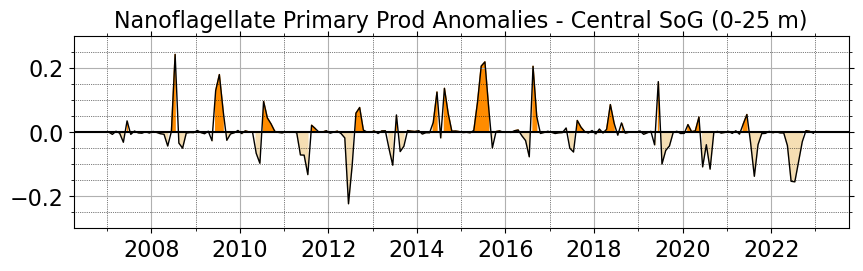

In [103]:
## mean anomalies for surface (0-50m) only

fig,ax=plt.subplots(1,1,figsize=(10,2.5))
x=tt
y=mean_anomalies_surf_flagPP


ax.plot(x,y,color='k',linewidth=1)
ax.set_ylim(-.3,.3)
plt.grid(True)
ax.minorticks_on()
#plt.grid(which='major',axis ='y', linewidth='1', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
ax.tick_params(which='both', # Options for both major and minor ticks
                top='off', # turn off top ticks
                left='off', # turn off left ticks
                right='off',  # turn off right ticks
                bottom='off') # turn off bottom ticks
hloc = YearLocator(1)
ax.xaxis.set_minor_locator(hloc)

ax.axhline(y=0,color='k',linestyle='-')


ax.fill_between(x,y,where=y<0, color='wheat')
ax.fill_between(x,y,where=y>0, color='darkorange')

ax.set_title('Nanoflagellate Primary Prod Anomalies - Central SoG (0-25 m)')
#plt.grid()
plt.show()

In [52]:
mean_anomalies_inter=np.mean((mod_PPDIAT_mean[23:28]-clim_PPDIAT[23:28])*86400,axis=0) ##20 = 25m depth

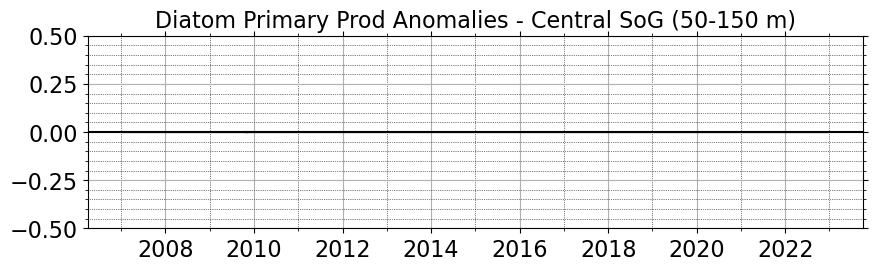

In [53]:
## mean anomalies for surface (0-50m) only

fig,ax=plt.subplots(1,1,figsize=(10,2.5))
x=tt
y=mean_anomalies_inter


ax.plot(x,y,color='k')
ax.set_ylim(-.5,.5)
plt.grid(True)
ax.minorticks_on()
#plt.grid(which='major',axis ='y', linewidth='1', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
ax.tick_params(which='both', # Options for both major and minor ticks
                top='off', # turn off top ticks
                left='off', # turn off left ticks
                right='off',  # turn off right ticks
                bottom='off') # turn off bottom ticks
hloc = YearLocator(1)
ax.xaxis.set_minor_locator(hloc)

ax.axhline(y=0,color='k',linestyle='-')


ax.fill_between(x,y,where=y<0, color='blue')
ax.fill_between(x,y,where=y>0, color='red')

ax.set_title('Diatom Primary Prod Anomalies - Central SoG (50-150 m)')
#plt.grid()
plt.show()